In [ ]:
import os
import tifffile
import pandas as pd
import scipy 
import json
import skimage
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, segmentation, feature
from scipy import ndimage as ndi
import skimage
import copy
from pathlib import Path
from roifile import ImagejRoi
from read_roi import read_roi_file

### LOAD AND PREPROCESS FUN

In [ ]:
def load_all_tiffs_from_day(base_day_folder):
    """
    Loads all TIFF files recursively from a day folder.
    Expected structure:
        day_folder/cell_number/protocol_type/file_folder/file.tif
    Returns a dictionary organized as:
        data_dict[cell][protocol][trial_name] = numpy array
    """
    data_dict = {}
    sd70_path = None
    
    for root, dirs, files in os.walk(base_day_folder):
        # --- Skip folders containing 'population' in their path ---
        if "population" in root.lower():
            print(f"⏭️  Skipping folder (population): {root}")
            # Optional: clear dirs to prevent descending further
            dirs[:] = []
            continue
        
        for f in files:
            if f.lower().endswith(('.tif', '.tiff')):
                full_path = os.path.join(root, f)
                # Split path components to extract hierarchy
                rel_path = os.path.relpath(full_path, base_day_folder)
                parts = rel_path.split(os.sep)

                # Expect at least 4 levels: cell / protocol / trial_folder / file
                if len(parts) < 4:
                    print(f"⚠️ Skipping {full_path}, unexpected structure.")
                    continue

                cell, protocol, trial_folder = parts[0], parts[1], parts[2]

                # Initialize nested dicts
                data_dict.setdefault(cell, {})
                data_dict[cell].setdefault(protocol, {})
                
                if "sd70-10" in root.lower():
                    sd70_path = full_path

                data_dict[cell][protocol][trial_folder] = tifffile.imread(full_path)

                # Load TIFF file
                print(f"📂 Loading: {cell} | {protocol} | {trial_folder} | {f}")
                data = tifffile.imread(full_path)

                # Store under structured key
                data_dict[cell][protocol][trial_folder] = data

    return data_dict, sd70_path

def find_roi_source_folders(base_day_folder):
    roi_candidates = {}

    for cell_folder in [os.path.join(base_day_folder, d) for d in os.listdir(base_day_folder) if os.path.isdir(os.path.join(base_day_folder, d))]:
        protocol_folders = [os.path.join(cell_folder, d) for d in os.listdir(cell_folder)
                            if os.path.isdir(os.path.join(cell_folder, d)) and "population" not in d.lower()]

        # Try to find SD or sensitivity folder
        sd_folder = next((p for p in protocol_folders if "spike" in os.path.basename(p).lower()), None)
        sens_folder = next((p for p in protocol_folders if "sens" in os.path.basename(p).lower()), None)

        roi_folder = sd_folder if sd_folder else sens_folder
        if roi_folder:
            roi_candidates[cell_folder] = roi_folder
            
    save_path = os.path.join(base_day_folder, "roi_sources.json")

    return roi_candidates

def load_roi_sources_json(base_dir):
    save_path = os.path.join(base_dir, "roi_sources.json")
    with open(save_path, "w") as f:
        json.dump(roi_sources, f, indent=2)
    print(f"✅ Saved all ROI sources in {save_path}")
    if os.path.exists(save_path):
        with open(save_path, "r") as f:
            return json.load(f)
    else:
        print("⚠️ No roi_sources.json found.")
        return {}

def calculate_spatial_average(data, dim_spatial_average_kernel_pix=3, disp_fig=False):
    data[np.isnan(data)] = np.nanmean(data)
    
    spatial_average_kernel = np.ones([dim_spatial_average_kernel_pix, dim_spatial_average_kernel_pix])
    cent_pix = np.ceil(np.divide(dim_spatial_average_kernel_pix - 1, 2)).astype(int)
    spatial_average_kernel[cent_pix, cent_pix] = 0

    if len(data.shape) > 2:
        spatial_average = np.mean([scipy.ndimage.convolve(_, spatial_average_kernel, origin=0) for _ in data], axis=0)
        norm = np.mean([scipy.ndimage.convolve(_, spatial_average_kernel, origin=0) for _ in np.ones_like(data)], axis=0)
        
    else:
        spatial_average = scipy.ndimage.convolve(data, spatial_average_kernel, origin=0)
        norm = scipy.ndimage.convolve(np.ones_like(data), spatial_average_kernel, origin=0)

    spatial_average = spatial_average/norm

    if disp_fig:
        fig, ax = plt.subplots()
        ax.imshow(spatial_average)
        plt.show()

    return spatial_average

def generate_segmentation_masks(img_to_segment, approx_radius_scanless_excitation_spot, disp_img=False):

    threshold_value = skimage.filters.threshold_otsu(img_to_segment)
    init_segmentation = np.ones_like(img_to_segment)
    init_segmentation[img_to_segment < threshold_value] = 0

    # keep largest segment
    labels = skimage.measure.label(init_segmentation, return_num=False)
    init_segmentation = labels == np.argmax(np.bincount(labels.flat, weights=init_segmentation.flat))
    
    tmp = skimage.morphology.disk(radius=approx_radius_scanless_excitation_spot/2)

    dilated_segmentation = skimage.morphology.dilation(init_segmentation, tmp)

    anti_cell_mask = copy.deepcopy(dilated_segmentation)
    anti_cell_mask = scipy.ndimage.binary_fill_holes(anti_cell_mask).astype(np.float64)
    anti_cell_mask = np.abs(anti_cell_mask - 1).astype(np.float64)

    if np.sum(anti_cell_mask) == 0: 
        anti_cell_mask[0,0] = 1
        anti_cell_mask[0,-1] = 1
        anti_cell_mask[-1,0] = 1
        anti_cell_mask[-1,-1] = 1

    if disp_img is True:      
        fig, axs = plt.subplots(nrows=1, ncols=4)
        # fig.set_size_inches(12,4)
        ax0, ax1, ax2, ax3 = axs
        ax0.imshow(img_to_segment)
        ax0.set_title("To segment")
        ax1.imshow(init_segmentation*img_to_segment)
        ax1.set_title("Initial segmentation")
        ax2.imshow(dilated_segmentation*img_to_segment)
        ax2.set_title("Dilated segmentation")
        ax3.imshow(anti_cell_mask*img_to_segment)
        ax3.set_title("Anti-cell mask")
        [ax.axis("off") for ax in axs]
        # fig.suptitle("Segmentation")
        plt.tight_layout()
        plt.show()

    return init_segmentation, dilated_segmentation, anti_cell_mask

def create_masks_from_sd_recording(sd_tiff, approx_radius_scanless_excitation_spot=15,
                                   spatial_kernel_pix=15, dff_percentile=90,
                                   disp_img=True):
    """
    Generate segmentation masks from SD70-10-1s recording:
    - Computes spatially averaged image
    - Computes ΔF/F activity map
    - Combines both for robust segmentation
    - Returns ROI (cell) and anti-ROI (background) masks
    """

    # Step 1. Replace NaNs
    data = sd_tiff.astype(float)
    data[np.isnan(data)] = np.nanmean(data)
        # Step 2. Compute spatial average (smoothing)
    spatial_average = calculate_spatial_average(data, dim_spatial_average_kernel_pix=spatial_kernel_pix, disp_fig=False)

    # Step 3. Compute ΔF/F per pixel
    f0 = np.percentile(data, 10, axis=0)  # baseline (10th percentile)
    fmax = np.percentile(data, dff_percentile, axis=0)
    dff = (fmax - f0) / np.maximum(f0, 1e-6)

    # Step 4. Normalize maps and combine them
    spatial_norm = (spatial_average - np.min(spatial_average)) / (np.max(spatial_average) - np.min(spatial_average))
    dff_norm = (dff - np.min(dff)) / (np.max(dff) - np.min(dff))
    combined_img = 0.5 * spatial_norm + 0.5 * dff_norm

    # Step 5. Use your segmentation function on the combined image
    init_segmentation, dilated_segmentation, anti_cell_mask = generate_segmentation_masks(
        combined_img,
        approx_radius_scanless_excitation_spot=approx_radius_scanless_excitation_spot,
        disp_img=disp_img
    )

    return init_segmentation, dilated_segmentation, anti_cell_mask, combined_img

day_folder = r"D:\Paris2025\ForceA Diluted x5\20251004"

data, sd70_path = load_all_tiffs_from_day(day_folder)
roi_sources = find_roi_source_folders(day_folder)
roi_sources = load_roi_sources_json(day_folder)


### CORRELATION IMAGE AND WATERSHED SEGMENTATION 

In [ ]:
# ✅ Now this works:
cell_folder, first_folder = list(roi_sources.items())[1]
first_folder = os.path.join(first_folder, '026-Sens70-2x2', '026-Sens70-2x2_NDTiffStack.tif')
spatial_average_kernel_pix = 25
expt_data = tifffile.imread(first_folder)
correlation_img = calculate_spatial_average(expt_data.astype(np.float32))

fig, ax = plt.subplots()
ax.imshow(correlation_img)
plt.show()
# binary mask of likely cells
thresh = filters.threshold_otsu(correlation_img)
binary_mask = correlation_img > thresh
distance = ndi.distance_transform_edt(binary_mask)
coords = feature.peak_local_max(distance, footprint=np.ones((10, 10)), labels=binary_mask)
markers = np.zeros_like(distance, dtype=int)
for i, (r, c) in enumerate(coords, start=1):
    markers[r, c] = i

# --- Watershed segmentation ---
labels = segmentation.watershed(-distance, markers=markers, mask=binary_mask)
labels = morphology.remove_small_objects(labels, min_size=300)

plt.figure()
plt.imshow(labels, cmap="nipy_spectral")
plt.show()

##MAYBE I SHOULD SAVE THE MASKS
roi_mask = labels > 0
np.save(os.path.join(cell_folder, "roi_mask.npy"), roi_mask)

### CORRELACTION IMAGE SEGMENTATION, MAKE AND SAVE MASKS

In [ ]:
light_on_off_buffer_nframes = 10
n_epochs = 1 # 50

segmentation_mask, dilated_segmentation_mask, dilated_background_mask, combined_img = create_masks_from_sd_recording(scipy.ndimage.gaussian_filter(correlation_img, 1), approx_radius_scanless_excitation_spot=20, spatial_kernel_pix=2, dff_percentile=100, disp_img=True)
segmented_data = segmentation_mask*correlation_img
segmented_data[segmented_data == 0] = np.nan

background_timeseries = np.divide(np.matmul(expt_data.reshape(expt_data.shape[0], -1), np.ravel(dilated_background_mask.astype(float))), np.sum(dilated_background_mask.astype(float)))
bg_sbtrkt_data = expt_data - np.expand_dims(np.expand_dims(background_timeseries, -1), -1)

init_timeseries = np.divide(np.matmul(bg_sbtrkt_data.reshape(bg_sbtrkt_data.shape[0], -1), np.ravel(segmentation_mask.astype(float))), np.sum(segmentation_mask.astype(float)))

fig, ax = plt.subplots(figsize=(10,3))
#plt.xlim(50, 800)
plt.ylim(5, 20)
ax.plot(init_timeseries)

plt.show()

estimated_epochs, _ = scipy.signal.find_peaks(np.abs(np.diff(init_timeseries)))
estimated_epochs = np.sort(estimated_epochs[np.argsort(np.abs(np.diff(init_timeseries))[estimated_epochs])[::-1][:2*n_epochs]])

est_epoch_duration  = []

for idxs in estimated_epochs.reshape(n_epochs,-1):
    est_epoch_duration.append(idxs[-1] - idxs[0])

est_epoch_duration = np.floor(np.mean(est_epoch_duration)).astype(int)

idxs_laser_on = []

for idxs in estimated_epochs.reshape(n_epochs,-1):
    idxs_laser_on.append(np.arange(idxs[0] + light_on_off_buffer_nframes,  idxs[0] + est_epoch_duration - light_on_off_buffer_nframes + 1))

idxs_laser_on_ravelled = copy.deepcopy(idxs_laser_on)
idxs_laser_on = np.array([x for xs in idxs_laser_on for x in xs])

print(len(idxs_laser_on))
print(f"Number of timeseries laser on detected: {len(init_timeseries)}")
all_epochs = [init_timeseries[idxs] for idxs in idxs_laser_on_ravelled[3:]]

# Save mask

print("✅ ROI mask saved.")

### AVG FOR SENS AND SUB, PLOT ALL TRACES 

cell_folder: D:\Paris2025\ForceA Diluted x5\20251004\cell2
Found 5 TIFF files for cell2
Loaded video: (15000, 36, 57)
Loaded mask: (36, 57)
Detected 12 epochs in 026-Sens70-2x2
Mean epoch length: 571 frames
Detected 40 epochs in 026-Sens70-2x2
Mean epoch length: 140 frames
Detected 47 epochs in 026-Sens70-2x2
Mean epoch length: 103 frames
Detected 47 epochs in 026-Sens70-2x2
Mean epoch length: 103 frames
Detected 47 epochs in 026-Sens70-2x2
Mean epoch length: 103 frames
Loaded video: (16908, 36, 57)
Loaded mask: (36, 57)
Detected 12 epochs in 027-sub-1
Mean epoch length: 530 frames
Detected 40 epochs in 027-sub-1
Mean epoch length: 167 frames
Detected 47 epochs in 027-sub-1
Mean epoch length: 145 frames
Detected 47 epochs in 027-sub-1
Mean epoch length: 145 frames
Detected 47 epochs in 027-sub-1
Mean epoch length: 145 frames
Loaded video: (20000, 36, 57)
Loaded mask: (36, 57)
Detected 12 epochs in 027-sub0.5
Mean epoch length: 596 frames
Detected 40 epochs in 027-sub0.5
Mean epoch leng

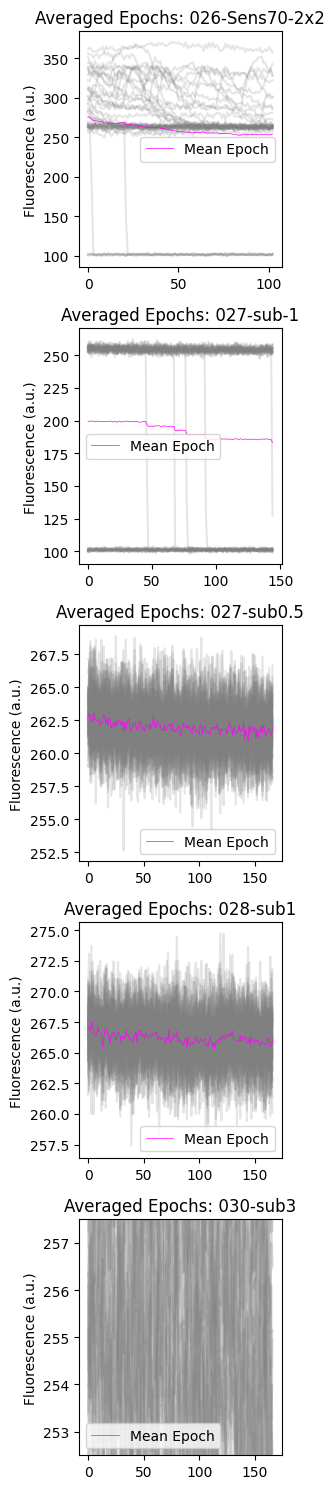

In [20]:
# labels: output of watershed (0 = background, 1,2,... = cells)
print("cell_folder:", cell_folder)
num_cells = labels.max()
cell_masks = [(labels == i).astype(float) for i in range(1, num_cells + 1)]
anti_masks = [1 - mask for mask in cell_masks]
def load_video(video_path):
    ext = os.path.splitext(video_path)[1].lower()
    if ext == '.roi':
        roi_path = os.path.join(cell_folder, 'roi_mask.roi')
        roi = ImagejRoi.fromfile(roi_path)
        mask = roi.to_mask(shape=(video_path.shape[1], video_path.shape[2]))
        return mask
    elif ext == '.npy':
        return np.load(video_path, allow_pickle=True)    
    elif ext in ['.tif', '.tiff']:
        return tifffile.imread(video_path)
    else:
        raise ValueError(f"Unsupported video format: {ext}")
    
from skimage.draw import polygon

def load_roi_mask(roi_path, shape):
    roi_dict = read_roi_file(roi_path)
    mask = np.zeros(shape, dtype=bool)

    for name, roi in roi_dict.items():
        if 'x' in roi and 'y' in roi:
            # Polygon or freehand ROI
            rr, cc = polygon(roi['y'], roi['x'], shape)
            mask[rr, cc] = True

        elif all(k in roi for k in ('left', 'top', 'width', 'height')):
            # Rectangle or oval ROI
            x0, y0 = roi['left'], roi['top']
            x1, y1 = x0 + roi['width'], y0 + roi['height']
            mask[y0:y1, x0:x1] = True

        else:
            print(f"⚠️ Unknown ROI type for '{name}', keys: {list(roi.keys())}")
    return mask

def extract_trace(video_path):
    video_stack = load_video(video_path)
    mask = load_roi_mask(os.path.join(cell_folder, 'roi_mask.roi'), video_stack.shape[1:]).astype(bool)

    # Ensure dimensions match
    if mask.shape != video_stack.shape[1:]:
        raise ValueError(f"Mask shape {mask.shape} does not match video frames {video_stack.shape[1:]}")

    masked_pixels = video_stack * mask
    trace = masked_pixels.sum(axis=(1,2)) / mask.sum()
    print("Loaded video:", video_stack.shape)
    print("Loaded mask:", mask.shape)
    return trace

cell_folder = Path(cell_folder)  # convert to Path object
cell_videos = {f.stem: tifffile.imread(f) for f in cell_folder.rglob("*_NDTiffStack.tif")}

def detect_epochs_and_average(trace, n_epochs=50, light_on_off_buffer_nframes=5):
    """Find repeated epochs based on signal changes, align, and average."""
    estimated_epochs, _ = scipy.signal.find_peaks(np.abs(np.diff(trace)))
    # pick the 2*n_epochs largest transitions (start/end of epochs)
    estimated_epochs = np.sort(
        estimated_epochs[np.argsort(np.abs(np.diff(trace))[estimated_epochs])[::-1][:2*n_epochs]]
    )
    # estimate epoch duration
    est_epoch_duration = []
    for idxs in estimated_epochs.reshape(n_epochs, -1):
        est_epoch_duration.append(idxs[-1] - idxs[0])
    est_epoch_duration = int(np.floor(np.mean(est_epoch_duration)))

    # collect per-epoch segments around stimulation
    idxs_laser_on = []
    for idxs in estimated_epochs.reshape(n_epochs, -1):
        idxs_laser_on.append(
            np.arange(
                idxs[0] + light_on_off_buffer_nframes,
                idxs[0] + est_epoch_duration - light_on_off_buffer_nframes + 1,
            )
        )

    # flatten and gather epochs
    idxs_laser_on_ravelled = copy.deepcopy(idxs_laser_on)
    all_epochs = [trace[idxs] for idxs in idxs_laser_on_ravelled[3:]]  # skip first 3 if noisy
    mean_epoch = np.mean(np.vstack(all_epochs), axis=0)
    return mean_epoch, all_epochs
# ----------------------------
video_files = []
for root, dirs, files in os.walk(cell_folder):
    for file in files:
        if file.endswith(".tif") and "population" not in root.lower():
            if "roi_mask" not in file.lower():
                video_files.append(os.path.join(root, file))

print(f"Found {len(video_files)} TIFF files for {os.path.basename(cell_folder)}")

n_epochs = [15, 43, 50, 50, 50]
light_on_off_buffer_nframes = 10

# ----------------------------
# PLOT RESULTS
# ----------------------------
n_files = len(video_files)
fig, axes = plt.subplots(n_files, 1, figsize=(3, 3 * n_files), sharex=False)

if n_files == 1:
    axes = [axes]
    
for ax, vfile in zip(axes, video_files):
    trace = extract_trace(vfile)
    name = os.path.basename(os.path.dirname(vfile)).lower()

    if "spikedet" in name:
        ax.plot(trace, color='black', lw=0.8)
        ax.set_title(f"Spike Detection Trace: {os.path.basename(os.path.dirname(vfile))}")

    elif "sens" in name or "sub" in name:
        for n_epoch in n_epochs:
            mean_epoch, all_epochs = detect_epochs_and_average(
                trace, n_epochs=n_epoch, light_on_off_buffer_nframes=light_on_off_buffer_nframes
            )
            print(f"Detected {len(all_epochs)} epochs in {os.path.basename(os.path.dirname(vfile))}")
            print(f"Mean epoch length: {len(mean_epoch)} frames")
        for epoch in all_epochs:
            ax.plot(epoch, color='gray', alpha=0.2)
        ax.plot(mean_epoch, color='magenta', lw=0.5, label="Mean Epoch")
        ax.legend()
        ax.set_title(f"Averaged Epochs: {os.path.basename(os.path.dirname(vfile))}")
        plt.ylim(252.5, 257.5)


    else:
        ax.plot(trace, color='gray', lw=0.8)
        ax.set_title(f"Unclassified Trace: {os.path.basename(os.path.dirname(vfile))}")

    ax.set_ylabel("Fluorescence (a.u.)")

plt.tight_layout()
plt.show()

## next, plot i-v curve 